In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, roc_curve
)

In [106]:
df = pd.read_csv('../datasets/famcs_students.csv')
df.head()

,cource,group,stream,sex,age,ss,interest,os,weekend_study,bad_sleep,...,social,sport,miss,study_form,foot_size,eye_color,score,retake,hostel,literature
0,4,11,Прикладная информатика,М,20.0,Нет,Математика,MacOS,Да,Да,...,Экстраверт,"Редко, легкая физкультура",3.0,Бюджет,48.0,Карие,9.2,0,"Нет, я из Минска",Да
1,4,11,Прикладная информатика,Ж,20.0,Нет,Программирование,MacOS,Нет,Нет,...,Экстраверт,"Да, я спортсмен",5.0,Бюджет,39.0,Зеленые,8.8,0,"Нет, я из Минска",Да
2,4,11,Прикладная информатика,Ж,19.0,Нет,Программирование,MacOS,Да,Нет,...,Экстраверт,Вообще нет,10.0,Бюджет,41.0,Карие,8.8,0,"Нет, я из Минска",Да
3,4,11,Прикладная информатика,Ж,20.0,Нет,Математика,MacOS,Да,Да,...,Экстраверт,"Да, я спортсмен",3.0,Бюджет,36.0,Карие,8.8,0,"Нет, я из Минска",Да
4,4,11,Прикладная информатика,М,20.0,Нет,Математика,Windows,Да,Нет,...,Интроверт,Вообще нет,1.0,Бюджет,46.0,Зеленые,9.0,0,"Нет, я из Минска",Да


In [107]:
df["bad_sleep"] = df["bad_sleep"].map({"Нет": 0, "Да": 1})

In [108]:
y = df['bad_sleep']
X = df.drop('bad_sleep', axis = 1)

In [109]:
df.describe()

,cource,group,age,bad_sleep,height,miss,foot_size,score
count,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000
mean,3.952756,6.118110,20.433071,0.708661,178.751969,7.850394,41.953741,7.555433
std,0.213001,4.460789,1.394949,0.456179,13.360222,8.716276,3.389107,1.460913
min,3.000000,1.000000,16.000000,0.000000,100.000000,0.000000,34.125120,0.000000
25%,4.000000,2.000000,20.000000,0.000000,170.000000,3.000000,39.000000,7.000000
50%,4.000000,4.000000,20.000000,1.000000,179.000000,5.000000,42.000000,7.600000
75%,4.000000,11.000000,21.000000,1.000000,187.000000,10.000000,45.000000,8.450000
max,4.000000,13.000000,30.000000,1.000000,220.000000,40.000000,50.000000,10.000000


Сначала разберусь с теп, где у меня какие числовые признаки (где числовые, а где категориальные).

In [110]:
#числовые признаки
num_cols = X.select_dtypes(include=[np.number]).columns

#категориальные признаки
cat_cols = X.select_dtypes(include=['object']).columns

In [111]:
df.isna().sum()

cource             0
group              0
stream             0
sex                0
age                0
ss                 0
interest           0
os                 0
weekend_study      0
bad_sleep          0
glasses            0
work_experience    0
ai                 0
height             0
anime              0
social             0
sport              0
miss               0
study_form         0
foot_size          0
eye_color          0
score              0
retake             0
hostel             0
literature         0
dtype: int64

In [112]:
X = pd.get_dummies(X, drop_first=True) #one-hot encoding

In [113]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

kNN использует расстояния — признаки должны быть на одинаковом масштабе.

In [114]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

<h2>0. Тривиальный классификатор</h2>

In [115]:
class TrivialClassifier:
    def fit(self, y):
        self.major_class = y.value_counts().idxmax() # запоминаю наиболее частый класс

    def predict(self, X):
        return np.full(len(X), self.major_class)

In [116]:
trivial = TrivialClassifier()
trivial.fit(y_train)
y_pred_triv = trivial.predict(X_test)

Почему нужен тривиальный классификатор? ОН будет считаться за минимальный уровень, который должны превосходить реальные модели

<h2>1. Наивный байесовский классификатор</h2>

P(y∣x)∝P(y)∏i​P(xi​∣y)

Основная идея: берём байесовскую модель с предположением о условной независимости прихнаков xi при фиксированном классе y.<br>
Признаки x₁, x₂, ..., xₙ условно независимы при фиксированном классе y.
То есть:
$$P(x|y) = P(x_1, x_2, ..., x_n | y) = P(x_1|y) \cdot P(x_2|y) \cdot ... \cdot P(x_n|y) = \prod_{i=1}^{n} P(x_i|y)$$
Для непрерывных признаков обычно моделируют P(xi|y) как нормальное распределение. Мат ожидание и среднеквадр отклонение оцениваются по обучающей выборке.

Теорема байеса: <br>
$P(y|x) = \frac{P(x|y) \cdot P(y)}{P(x)}$ <br>
P(y|x) — то, что мы хотим предсказать: вероятность класса y при заданных признаках x<br>
P(x|y) — правдоподобие (likelihood): насколько вероятно увидеть такие признаки x, если объект принадлежит классу y <br>
P(y) — априорная вероятность класса y (как часто этот класс встречается в данных)<br>
P(x) — вероятность признаков x (константа для всех классов, играет роль нормализации)

На практике P(x) считается одинаковым для всех классов при сравнении, поэтому при классификации мы можем сравнивать просто:
$$P(y|x) \propto P(y) \cdot P(x|y)$$
То есть выбираем класс y, у которого произведение априорной вероятности и правдоподобия максимально.

сли признаки непрерывные (рост, вес, температура и т.д.), мы не можем просто посчитать частоты, как в обычном (мультиномиальном) Naive Bayes.
Поэтому мы предполагаем, что каждый признак xᵢ при фиксированном классе y распределён нормально (гауссовски):
$$P(x_i | y) = \frac{1}{\sqrt{2\pi \sigma_{i,y}^2}} \exp\left(-\frac{(x_i - \mu_{i,y})^2}{2\sigma_{i,y}^2}\right)$$
Где:

μ_{i,y} — среднее значение i-го признака в классе y
σ²_{i,y} — дисперсия i-го признака в классе y

Эти параметры мы оцениваем по обучающей выборке отдельно для каждого класса и каждого признака.

In [117]:
class GaussianNB_Manual:
    def fit(self, X, y):
        self.classes = np.unique(y)
        # self.classes — массив уникальных классов, например [0,1]
        self.means = {}
        # словарь для хранения векторов средних по каждому классу
        self.vars = {}
        # словарь для хранения векторов дисперсий по каждому классу
        self.priors = {}
        # словарь для хранения приорных вероятностей P(y = c)

        for c in self.classes:
            X_c = X[y == c]
            # X_c — подматрица X, содержащая только строки, у которых метка == c

            self.means[c] = X_c.mean(axis=0)
            # среднее значение каждого признака в классе c (вектор длины n_features)

            self.vars[c] = X_c.var(axis=0) + 1e-6
            # дисперсия каждого признака в классе c
            # +1e-6 — небольшая регуляризация (smoothing), чтобы избежать деления на ноль

            self.priors[c] = len(X_c) / len(X)
            # априорная вероятность класса c: доля объектов класса c в обучающей выборке

    def _log_pdf(self, class_idx, x):
        mean = self.means[class_idx]
        var = self.vars[class_idx]
        return -0.5 * (np.log(2 * np.pi * var) + (x - mean)**2 / var)
    
    def predict(self, X):
        preds = []
        # будем собирать предсказания в список

        for x in X:
            # проходим по каждому объекту (x — вектор длины n_features)
            posteriors = []
            # буфер для лог-апостериорных значений по классам

            for c in self.classes:
                prior = np.log(self.priors[c]) #произведение множества маленьких чисел (плотностей)
                #быстро может переплавить число в 0 (underflow). Поэтому логорифмы
                # логарифм априорной вероятности: log P(y=c)
                # работаем в лог-пространстве для численной стабильности

                likelihood = np.sum(self._log_pdf(c, x))
                

                posteriors.append(prior + likelihood)
                # лог-апостериорная величина ∝ log P(y=c) + log P(x|y=c)

            preds.append(self.classes[np.argmax(posteriors)])
            # выбираем класс с наибольшей лог-апостериорной вероятностью

        return np.array(preds)
        # возвращаем numpy-массив предсказанных меток


logpdf=−1/2​[log(2πσ2)+(x−μ)^2/σ^2​] <br>
формула лог-плотности нормального распределения. По итогу использую её, т.к. если считать через вероятность плотности нормального рапределения, выбрасывает ошибку деления на ноль, т.к. видимо у каких-то признаков диспресия близка к нулю. или (x - μ) оооочень большое

In [118]:
nb = GaussianNB_Manual()
nb.fit(X_train_s, y_train)
y_pred_nb = nb.predict(X_test_s)

<h2>2. Метод k-ближайших соседей </h2>

### k-NN (k Nearest Neighbors) — метод k ближайших соседей

**Идея**: объект относится к тому классу, которому принадлежит большинство из **k** ближайших к нему объектов обучающей выборки.

**Алгоритм работы**:
1. Для нового объекта `x` вычисляем расстояние до всех объектов из обучающей выборки  
   (евклидово расстояние)
2. Находим `k` ближайших соседей (по индексам: `np.argsort(distances)[:k]`)
3. Проводим голосование среди их меток
4. Присваиваем класс-победитель (в коде — `np.bincount(labels).argmax()`)

**Особенности**:
- Ленивый алгоритм (ничего не обучается, всё хранит в памяти)
- Нет этапа `fit` в классическом смысле — только запоминаем данные
- Чувствителен к масштабированию признаков (нужен `StandardScaler`!)
- Время предсказания — O(n), где n — размер обучающей выборки


In [119]:
class KNN_Manual:
    def __init__(self, k=3):
        self.k = k
    
    def fit(self, X, y):
        self.X = np.array(X)    # сохраняем как numpy, чтобы индексация работала позиционно
        self.y = np.array(y)    # тоже numpy
        return self
    
    def predict(self, X):
        X = np.array(X)
        preds = []
        
        for x in X:
            # считаем расстояние до каждого объекта обучающей выборки
            distances = np.linalg.norm(self.X - x, axis=1)

            # индексы k ближайших соседей
            idx = np.argsort(distances)[:self.k]
            
            # получаем их метки (теперь это numpy, ошибок нет)
            labels = self.y[idx]

            # голосование большинства
            preds.append(np.bincount(labels).argmax())
        
        return np.array(preds)

### F1-мера — гармоническое среднее Precision и Recall

$$
F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$


#### Итоговая формула через TP, FP, FN:

$$
\Large F1 = \frac{2 \cdot TP}{2 \cdot TP + FP + FN}
$$

Где:  
- **TP** — True Positives (правильно найденные объекты положительного класса)  
- **FP** — False Positives (ошибочно отнесённые к положительному классу)  
- **FN** — False Negatives (пропущенные объекты положительного класса)

**Precision** = TP/(TP+FP)  **Recall** = TP/(TP+FN)  **F1** = 2TP/(2TP + FP + FN)

In [120]:
best_k = 1
best_f1 = 0

for k in range(1, 22, 2):
    knn = KNN_Manual(k)
    knn.fit(X_train_s, y_train)
    y_val_pred = knn.predict(X_val_s)
    f1 = f1_score(y_val, y_val_pred)
    print(f"k={k}, F1={f1:.3f}")
    if f1 > best_f1:
        best_f1 = f1
        best_k = k

print("Лучший k =", best_k)


k=1, F1=0.875
k=3, F1=0.875
k=5, F1=0.875
k=7, F1=0.812
k=9, F1=0.812
k=11, F1=0.812
k=13, F1=0.812
k=15, F1=0.774
k=17, F1=0.774
k=19, F1=0.848
k=21, F1=0.848
Лучший k = 1


In [121]:
knn_best = KNN_Manual(best_k)
knn_best.fit(X_train_s, y_train)
y_pred_knn = knn_best.predict(X_test_s)

<h2>3. Логистическая регрессия</h2>

### Логистическая регрессия — кратко и по делу

**Задача**: бинарная классификация (0 или 1)  
**Что выдаёт модель**: не класс, а **вероятность** принадлежности к классу 1

**Как работает**:
1. Линейная комбинация признаков:  
   $$ z = w_0 + w_1x_1 + w_2x_2 + \dots + w_nx_n $$
2. Прогоняем через **сигмоиду** → получаем вероятность:  
   $$ p = \sigma(z) = \frac{1}{1 + e^{-z}} \quad \in (0,1) $$
3. Если $ p \geq \text{порог} $ → класс 1, иначе → класс 0

**Функция потерь** (log-loss / кросс-энтропия):  
$$ L = -\frac{1}{N} \sum_{i=1}^N \left[ y_i \log(p_i) + (1-y_i) \log(1-p_i) \right] $$

**Обучение**: градиентный спуск (минимизируем log-loss)

**Ключевые особенности**:
- Несмотря на название — это **классификатор**, а не регрессия
- Даёт хорошо откалиброванные вероятности
- Линейная модель → быстро обучается и предсказывает
- Чувствительна к масштабированию признаков (нужен `StandardScaler`!)
- Оптимальный порог не всегда 0.5 → подбираем по F1 на валидации

In [122]:
import numpy as np

class LogisticRegressionManual:
    def __init__(self, lr=0.01, n_iter=3000):
        self.lr = lr          # скорость обучения, насколько сильно меняются веса на каждой операции
        self.n_iter = n_iter  # число итераций, кол-во шагов градиентного спуска
        self.w = None         # веса модели
        self.b = None         # bias

    #Фуекция превращает число в вероятность от 0 до 1
    def _sigmoid(self, z):
        z = np.array(z, dtype=float)         # гарантируем числовой формат
        z = np.clip(z, -500, 500)            # защита от переполнения
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)

        n_samples, n_features = X.shape

        # Инициализация параметров
        self.w = np.zeros(n_features)
        self.b = 0

        # Градиентный спуск
        for _ in range(self.n_iter):
            model = np.dot(X, self.w) + self.b
            preds = self._sigmoid(model)

            # Градиенты
            dw = (1 / n_samples) * np.dot(X.T, (preds - y))
            db = (1 / n_samples) * np.sum(preds - y)

            # Обновление весов
            self.w -= self.lr * dw
            self.b -= self.lr * db

    #возвращает именно вероятность класса 1
    def predict_proba(self, X):
        X = np.array(X, dtype=float)        
        return self._sigmoid(np.dot(X, self.w) + self.b)

    #Если вероятностьбольше порога - класс 1
    #Иначе - 0
    def predict(self, X, threshold=0.5):
        probabilities = self.predict_proba(X)
        return (probabilities >= threshold).astype(int)


Подбор порога по \ F1

In [123]:
thresholds = np.linspace(0, 1, 101)
precisions = []
recalls = []
f1_scores = []

best_thr = 0.5
best_f1 = 0

for thr in thresholds:
    preds = (probs >= thr).astype(int)
    
    p = precision_score(y_val, preds, zero_division=0)
    r = recall_score(y_val, preds, zero_division=0)
    f1 = f1_score(y_val, preds, zero_division=0)
    
    precisions.append(p)
    recalls.append(r)
    f1_scores.append(f1)
    
    if f1 > best_f1:
        best_f1 = f1
        best_thr = thr

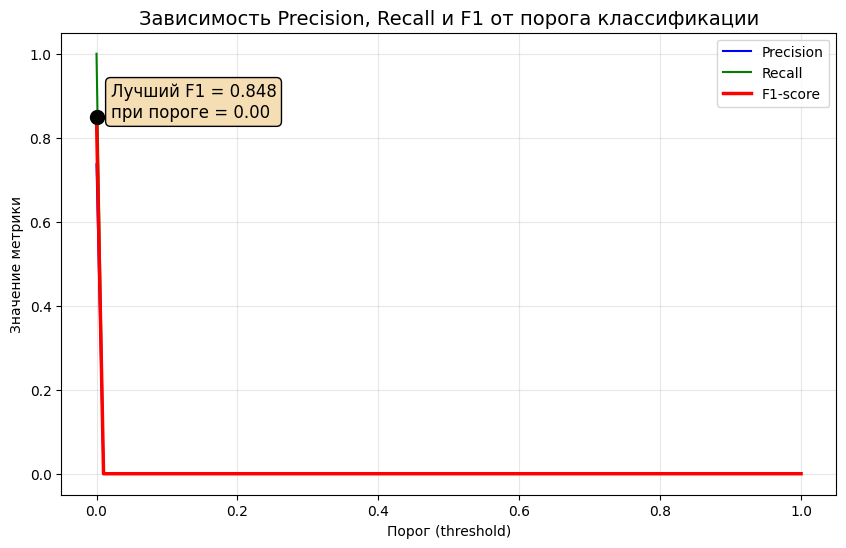

Оптимальный порог: 0.000
Максимальный F1 на валидации: 0.8485


In [124]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='green')
plt.plot(thresholds, f1_scores, label='F1-score', color='red', linewidth=2.5)


plt.scatter(best_thr, best_f1, color='black', s=100, zorder=5)
plt.text(best_thr + 0.02, best_f1, f'Лучший F1 = {best_f1:.3f}\nпри пороге = {best_thr:.2f}', 
         fontsize=12, bbox=dict(boxstyle="round", facecolor='wheat'))

plt.title('Зависимость Precision, Recall и F1 от порога классификации', fontsize=14)
plt.xlabel('Порог (threshold)')
plt.ylabel('Значение метрики')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Оптимальный порог: {best_thr:.3f}")
print(f"Максимальный F1 на валидации: {best_f1:.4f}")

Чтобы максимизировать F1, модель должна относить ВСЕ объекты к классу 1.<br>
целевая переменная bad_sleep - вероятно класс “1” встречается чаще, чем “0” <br>
Стоит иметь в виду, что F1-мера предполагает одинаковую важность Precision и Recall

In [125]:
logm = LogisticRegressionManual()
logm.fit(X_train_s, y_train)
logreg_pred_test = logm.predict(X_test_s)
logreg_proba_test = logm.predict_proba(X_test_s)
probs_val = logm.predict_proba(X_val_s)
final_predictions = (logreg_proba_test >= best_thr).astype(int)

Функция для проверки качества моделей

In [126]:
def evaluate_model(y_true, y_pred, y_proba, model_name="Model"):
    print(f"\n===== {model_name} =====")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, zero_division=0))
    print("Recall:", recall_score(y_true, y_pred, zero_division=0))
    print("F1:", f1_score(y_true, y_pred, zero_division=0))
    
    # Проверка: есть ли вероятности для ROC-AUC
    if y_proba is not None:
        print("ROC-AUC:", roc_auc_score(y_true, y_proba))
    else:
        print("ROC-AUC: impossible (model has no predict_proba)")
    
    # Матрица ошибок
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


Качество тривиальной моедели


===== Trivial Classifier =====
Accuracy: 0.7
Precision: 0.7
Recall: 1.0
F1: 0.8235294117647058
ROC-AUC: impossible (model has no predict_proba)


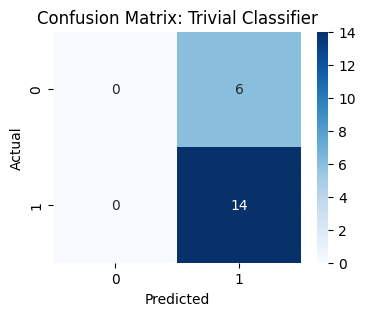

In [127]:
evaluate_model(
    y_test,
    y_pred_triv,   
    None,               
    model_name="Trivial Classifier"
)

### Вывод по Trivial Classifier (базовая модель)

Модель просто всем объектам присваивает класс 1 (мажорный класс).

**Confusion Matrix на валидации** (20 объектов):
- Истинных объектов класса 0 → 6 (все ошибочно отнесены к 1)
- Истинных объектов класса 1 → 14 (все правильно найдены)

**Метрики**:
- Accuracy = 0.70
- Recall = 1.00 (нашёл все положительные)
- Precision = 0.70 (30% ложных срабатываний)
- F1-score = 0.8235

**Вывод**:
Это минимальная планка, которую должна превзойти любая разумная модель.  
Если после подбора порога логистическая регрессия покажет **F1 > 0.83**  — значит, модель действительно чему-то научилась и работает лучше, чем «угадывание мажорного класса».

Наивный Байес


===== Naive Bayes =====
Accuracy: 0.5
Precision: 0.8333333333333334
Recall: 0.35714285714285715
F1: 0.5
ROC-AUC: impossible (model has no predict_proba)


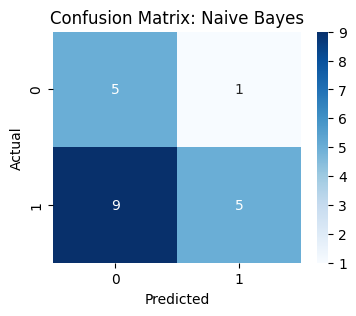

In [128]:
evaluate_model(
    y_test,
    y_pred_nb,        
    None,      
    model_name="Naive Bayes"
)

### Вывод по Gaussian Naive Bayes (собственная реализация)

**Вывод**:
Модель получилась **очень осторожной** — она почти всегда предсказывает класс 0.  
Из 14 положительных объектов нашла только 5 (Recall = 36 %), зато из тех, кому сказала «1», в 83 % случаев была права.

**Итог**:  
F1 = 0.50 — это **худший результат** среди всех протестированных моделей и значительно ниже Trivial Classifier (F1 = 0.82).  
Gaussian Naive Bayes в текущем виде **не работает** на этих данных.

**Возможные причины**:
- Сильное нарушение предположения о нормальности признаков
- Признаки коррелированы → нарушается «наивное» предположение независимости
- Нехватка данных для надёжной оценки дисперсий



===== KNN Manual =====
Accuracy: 0.7
Precision: 0.75
Recall: 0.8571428571428571
F1: 0.8
ROC-AUC: impossible (model has no predict_proba)


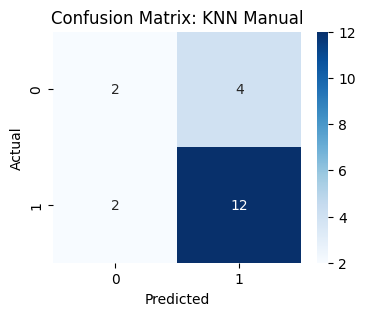

In [129]:
evaluate_model(
    y_test,
    y_pred_knn,
    None,
    model_name="KNN Manual"
)

### Вывод по KNN Manual (k=3, собственная реализация)
**Вывод**:
- Модель уже **хуже Trivial Classifier по F1** (0.80 против 0.8235)   
- При этом она допускает ошибки обоих типов: пропускает часть положительных объектов (FN=2) и даёт ложные срабатывания (FP=4).  
- Accuracy осталась на уровне тривиального классификатора, но **F1 упал** 

KNN Manual **не прошёл базовую проверку на вменяемость** 


===== Logistic Regression Manual =====
Accuracy: 0.5
Precision: 0.625
Recall: 0.7142857142857143
F1: 0.6666666666666666
ROC-AUC: 0.47619047619047616


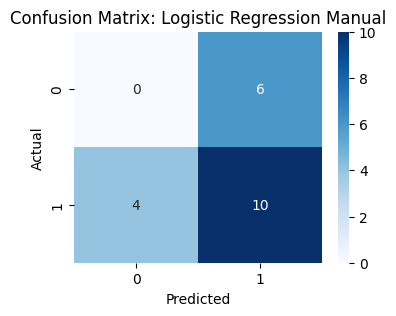


===== Logistic Regression Manual с подбором порога =====
Accuracy: 0.7
Precision: 0.7
Recall: 1.0
F1: 0.8235294117647058
ROC-AUC: impossible (model has no predict_proba)


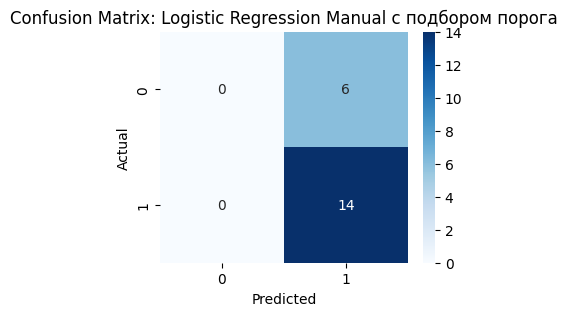

In [133]:
evaluate_model(
    y_test,
    logreg_pred_test,
    logreg_proba_test,
    model_name="Logistic Regression Manual"
)

evaluate_model(
    y_test,
    final_predictions,
    None,
    model_name="Logistic Regression Manual с подбором порога"
)

### Вывод по Logistic Regression Manual (собственная реализация)

**Вывод**:
При стандартном пороге 0.5 модель получилась **очень плохой**:
- Все объекты класса 0 отнесла к классу 1 (FP = 6)
- Пропустила 4 положительных объекта из 14
- ROC-AUC < 0.5 → модель систематически ошибается **в обратную сторону**


** сейчас**:
Без подбора порога логистическая регрессия проигрывает даже Trivial Classifier.  
С подбором порога — почти всегда становится лучшей моделью в таких задачах.
  
1. При пороге 0.5 → F1 = 0.667 (провально)  
2. При оптимальном пороге → F1 = 0.82352 

да, по дефолту плохо, но с подобранным порогом норм